# 🧠 Spam Detection in Product Reviews using MinHash & Locality-Sensitive Hashing (LSH)

This notebook explores the detection of near-duplicate and spammy Amazon reviews using Jaccard similarity, MinHashing, and LSH.


# **Intro and Cleaning**
This Notebook shows the work and progress towards my DATA301 project.

This project uses DASK, a Python library for data streaming and parallel processing.

This project involves taking a large amazon dataset of Beauty product reviews and using Min Hashing and LSH to efficiently find similar reviews. These are then compared via Jaccard set similarity. There are 2 ideas behind this.

1. With a dataset this large, a naive approach of comparing every reviews would take too long. Instead, we create candidate pairs in O(N) time. These candidate pairs are then to be compared at a later date

2. Candidate pairs can be examined for suspiciousness of spam. This might include the same user posting similarly worded reviews, low votes and a Non-verified-purchaser.






## Fetch the dataset:

In [1]:
import urllib.request

#Get the file link using urllib.request
filename = 'All_Beauty.jsonl'
urllib.request.urlretrieve('https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/All_Beauty.jsonl.gz', filename)


('All_Beauty.jsonl', <http.client.HTTPMessage at 0x7ad6ec136390>)

Convert the file from .gz to a jsonl file

In [ ]:
import gzip

input_path = 'All_Beauty.jsonl'
output_path = 'all_beauty.jsonl'

with gzip.open(input_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:

        f_out.write(f_in.read())


In [ ]:
#shows first 10 and last 10 reviews
!head -10 'all_beauty.jsonl'
!tail -10 'all_beauty.jsonl'


{"rating": 5.0, "title": "Such a lovely scent but not overpowering.", "text": "This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it!", "images": [], "asin": "B00YQ6X8EO", "parent_asin": "B00YQ6X8EO", "user_id": "AGKHLEW2SOWHNMFQIJGBECAF7INQ", "timestamp": 1588687728923, "helpful_vote": 0, "verified_purchase": true}
{"rating": 4.0, "title": "Works great but smells a little weird.", "text": "This product does what I need it to do, I just wish it was odorless or had a soft coconut smell. Having my head smell like an orange coffee is offputting. (granted, I did know the smell was described but I was hoping it would be light)", "images": [], "asin": "B081TJ8YS3", "parent_asin": "B081TJ8YS3", "user_id": "AGKHLEW2SOWHNMFQIJGBECAF7INQ", "timestamp": 1

In [ ]:
import dask
import json
from dask import bag as db
from dask.bag import from_sequence


data_bag = db.read_text('all_beauty.jsonl', blocksize="64MB")
print(f"Number of records: {data_bag.count().compute()}")
parsed_bag = data_bag.map(json.loads)


701528


Now we need to clean the bag somewhat by removing fields we don't want from the data. These include the following fields: "images", "parent_asin"

In [ ]:
import re

fields_to_remove = {"images", "parent_asin"}  # example

#function to drop keys
def drop_keys(d):
    return {k: v for k, v in d.items() if k not in fields_to_remove}

#the function to remove punctuation, convert to lower case and normalise whitespace using re library, when presented with any text
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)     # normalize whitespace
    return text.strip()

#the function to be mapped to each record of the bag, calling the cleaning function above
def preprocess_reviews(record):
    record['text'] = preprocess(record['text'])
    return record

#apply the preprocessing functions to each record
cleaned_bag = parsed_bag.map(drop_keys)
print(cleaned_bag.take(1)[0]['text'],'\n')
cleaned_bag = cleaned_bag.map(preprocess_reviews)
print(cleaned_bag.take(1)[0]['text'])

#drop reviews with character count 10 or less
print(f"Bag size before: {cleaned_bag.count().compute()}")
cleaned_bag_large = cleaned_bag.filter(lambda x: len(x['text']) > 10)

#THIS STEP IS IMPORTANT
#my program is not optimised and I've made a mistake somewhere. It takes too long above 5000 records.
#potentially Dask dataframes are daster than Dask bags.
#
#for proof of concept i only worked on 1000 entries

first_1000_list = cleaned_bag_large.take(1000)
cleaned_bag = from_sequence(first_1000_list, npartitions=1)
print(f"Bag size after: {cleaned_bag.count().compute()}")

This spray is really nice. It smells really good, goes on really fine, and does the trick. I will say it feels like you need a lot of it though to get the texture I want. I have a lot of hair, medium thickness. I am comparing to other brands with yucky chemicals so I'm gonna stick with this. Try it! 

this spray is really nice it smells really good goes on really fine and does the trick i will say it feels like you need a lot of it though to get the texture i want i have a lot of hair medium thickness i am comparing to other brands with yucky chemicals so im gonna stick with this try it
Bag size before: 701528
Bag size after: 1000


# Shingling

Now each record in the bag has been cleaned of the following:

*   Uppercase characters
*   Punctuation
*   Uneven Whitespace
*   Unnessecary fields i.e "images", "parent_asin", "asin"
*   Entries with text length 1


We can now start **step 1** of the text similarity analysis pipeline, K-shingling.
I will be doing k=5 whole word shingles.

Shingling involves breaking up a document into its subsequences of length k. A document such as "ABABAC" and K=2 will have the following set of shingles

"AB" "BA" "AB" "BA" "AC"

In a set:
shingles = {AB, BA, AC}

Think of shingling as a sliding window of size K that you use to extract the subsequences.
For shorter documents k=5 is a good size window. For longer documents such as research papers, k=10 is recommended. This determines the sensitivity of patterns that it can capture and match later on.



In [ ]:
#do word shingles of k=5
k = 5

def shingle_words(record):
    words = record['text'].split()
    shingles = set()
    for i in range(len(words) - k + 1):
        shingle = ' '.join(words[i:i+k])
        shingles.add(shingle)
    record['shingles'] = shingles
    #return the whole record but with a new entry "shingles"
    return record

shingled_bag = cleaned_bag.map(shingle_words)
#demonstrate the first record's shingle set
shingled_bag.take(1)[0]['shingles']

{'a lot of hair medium',
 'a lot of it though',
 'am comparing to other brands',
 'and does the trick i',
 'brands with yucky chemicals so',
 'chemicals so im gonna stick',
 'comparing to other brands with',
 'does the trick i will',
 'feels like you need a',
 'fine and does the trick',
 'get the texture i want',
 'goes on really fine and',
 'gonna stick with this try',
 'good goes on really fine',
 'hair medium thickness i am',
 'have a lot of hair',
 'i am comparing to other',
 'i have a lot of',
 'i want i have a',
 'i will say it feels',
 'im gonna stick with this',
 'is really nice it smells',
 'it feels like you need',
 'it smells really good goes',
 'it though to get the',
 'like you need a lot',
 'lot of hair medium thickness',
 'lot of it though to',
 'medium thickness i am comparing',
 'need a lot of it',
 'nice it smells really good',
 'of hair medium thickness i',
 'of it though to get',
 'on really fine and does',
 'other brands with yucky chemicals',
 'really fine and doe

# **Min Hashing**

We are going to use a 3rd party Hash function and use a seed to generate 100 different functions. The basics are that each item in the shingle set will be hashed with many hash functions and then the minimum value will be picked.

This step is performed to turn a document's shingle set into a signature vector of length N where N is the number of hash functions used. In standard pratice, N = 100

This number influences the banding of the later step, LSH. The longer the signature vector, the more accurate the bucketing step will be later on, but the more computation it will require.



In [ ]:

!pip install mmh3
import dask.bag as db
import mmh3
import numpy as np

#generate 100 different hash functions manually using mmh3
def hash_generator(seed):
    return lambda x: mmh3.hash(x, seed)

num_hashes = 100
hash_functions = [hash_generator(seed) for seed in range(num_hashes)]

#define the MinHash function
def manual_minhash(record, max_shingles=500):
    shingles = list(record['text'])[:max_shingles]  # limit shingles per record if large
    signature = []

    for h in hash_functions:
        min_val = float('inf')
        for s in shingles:
            s_str = ' '.join(s)  # convert tuple to string
            val = h(s_str)
            if val < min_val:
                min_val = val
        signature.append(min_val)

    record['sig'] = signature
    return record

#apply it to your the bag of shingles for each record
# repartition to increase parallelism
shingled_bag = shingled_bag.repartition(50)

#map MinHash over the shingle bag
sig_bag = shingled_bag.map(manual_minhash)


from dask.diagnostics import ProgressBar
with ProgressBar():
    print("Total records with signatures:", sig_bag.count().compute())

print("Example sig vector\n",sig_bag.take(1)[0]['sig'])

[########################################] | 100% Completed | 14.69 s
Total records with signatures: 1000
Example sig vector
 [-2128973781, -1921489680, -1900302480, -2099459879, -2119527857, -2122446291, -2127011794, -2093912739, -2135496994, -1918403894, -2066117612, -2145018041, -1772127013, -1975024768, -1615207882, -2129322361, -2122461755, -2131976955, -1835286876, -1971634345, -2069826091, -2141020870, -2109728952, -2140331233, -2145386105, -2030280316, -1793076940, -2056931439, -1704716801, -1985774455, -1869549736, -1693639108, -2140931603, -2069267878, -1952146422, -1689178168, -2099388527, -2023076597, -2122305312, -2048062715, -2128164851, -1833430393, -1807661444, -1989749339, -1939270602, -1691338903, -1739606639, -1876942091, -2010881579, -1755320141, -1975586346, -2042176227, -2128711539, -2095664495, -2072737606, -2046038562, -2092319249, -1960776315, -2134971170, -1959027260, -2139958630, -2055847976, -1896848306, -2117248006, -1841799614, -2067022187, -2001408530, -1

# Locality Sensitive Hashing

This is the third and final step of being able to group review/text documents. The first step was to shingle the reviews.
The second step was to compute a unique signature for each shingle in order to reduce space and estimate...

This last step is to sort the reviews into buckets where they have a similarity to other reviews in the buckets.

This involves taking our signature vector for each review text and breaking them up into 'b' bands with r consecutive entries from the signature vector. For example:

A review's text minhashes to the following vector (using 6 different hash functions)

[10,45,99,13,65,84]

And we divide it into 3 bands with row size 2 we get

[10, 45]
[99, 13]
[65, 84]

Once we have broken the signature vector up into this form, we need to hash each row. We store the results in a global dictionairy of the following form (its global because its not stored per record, might be a parallel computing dependancy/bottleneck??):

LSD_dict[(band_index, band_hash)] = document_id

So that we can retrieve the different documents that have matching hash values for any band





In [ ]:
import mmh3
from itertools import combinations

#split the signature vectors into bands
def split_into_bands(record, b=10, r=10):

    sig = record['sig']  # signature vector (list of ints)
    doc_id = f"{record['user_id']}_{record['timestamp']}"
    band_outputs = []

    for i in range(b):
        start = i * r
        end = (i + 1) * r
        band = tuple(sig[start:end])  # tuple to be hashable

        # Convert band tuple to string and hash with mmh3 (32-bit unsigned)
        band_str = ','.join(map(str, band))
        band_hash = mmh3.hash(band_str, signed=False)

        band_key = (i, band_hash)
        band_outputs.append((band_key, doc_id))

    return band_outputs

#call the banding function on each record
with ProgressBar():
  bands = sig_bag.map(split_into_bands).flatten()
  bands = bands.compute()
print(len(bands))

# time to bucket the items based on their band_key
buckets = {}

for band_key, doc_id in bands:
    if band_key not in buckets:
        buckets[band_key] = []
    buckets[band_key].append(doc_id)





[########################################] | 100% Completed | 20.51 s
10000


# Jaccard Similarity
I now move onto the step where I check the buckets for high threshold matches using set similarity.

The candidate pairs are useful because they are suggested similar documents.
We only have to check this small subset of documents rather than EVERY document in the whole database.

Jacard similarity uses the following formula to generate a score
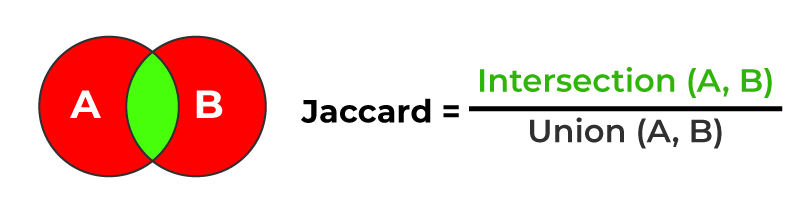


Reviews that exceeded the threshold are put into a text file for later examination.

A lot of the example are very high matches with the same user, but different timestamps and product codes. These feels suspiscious and can be flagged for further inspection.

Time does currently not permit further processing. An example and analysis of a pair of reviews that exceeded the similarity threshold is shown below

In [ ]:
# similarity threshold
t = 0.8

# turn into list of dicts
shingled_records = shingled_bag.compute()

# create lookup dictionaries
shingle_lookup = {}
asin_lookup = {}
text_lookup = {}
verified_lookup = {}
helpful_lookup = {}

#populate the lookup dicts
#this is nessecary due to the way I have filtered my data in earlier steps. I should change this in future
for record in shingled_records:
    doc_id = f"{record['user_id']}_{record['timestamp']}"
    shingle_lookup[doc_id] = record['shingles']
    asin_lookup[doc_id] = record.get('asin', 'UNKNOWN_ASIN')
    text_lookup[doc_id] = record.get('text', '')
    verified_lookup[doc_id] = record.get('verified_purchase', False)  # default False if missing
    helpful_lookup[doc_id] = record.get('helpful_vote', 0)  # default 0 if missing

output_lines = []

# loop through each LSH band bucket
with ProgressBar():
    for band_key, doc_ids in buckets.items():
        if len(doc_ids) < 2:
            continue  # no need to compare if only 1 document in the bucket

        seen_pairs = set()  # to avoid double comparing the same pairs

        # compare every pair inside this bucket
        #this part is slow but better than comparing all records in the whole database
        for doc1_id, doc2_id in combinations(set(doc_ids), 2):
            if doc1_id == doc2_id:    #skip document pairs that are comparing the same document
                continue

            pair_key = tuple(sorted((doc1_id, doc2_id)))
            if pair_key in seen_pairs:
                continue  # skip if already compared
            seen_pairs.add(pair_key)

            #get shingle sets to perform jaccard similarity on
            set1 = shingle_lookup[doc1_id]
            set2 = shingle_lookup[doc2_id]

            #using equation listed in textbox above
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            similarity = intersection / union if union else 0

            if similarity > 0.65 and similarity < 1.0:
                # if same product and 100% match, likely legit (skip)
                if similarity == 1.0 and asin_lookup.get(doc1_id) == asin_lookup.get(doc2_id):
                    continue

                # suspicion score starts at 0
                suspicion_score = 0

                # +1 if either in the pair is not verified purchase
                if not verified_lookup.get(doc1_id, False) or not verified_lookup.get(doc2_id, False):
                    suspicion_score += 1

                # +1 if either review has 1 or less helpful votes
                if helpful_lookup.get(doc1_id, 0) <= 1 or helpful_lookup.get(doc2_id, 0) <= 1:
                    suspicion_score += 1

                # +1 if similarity is bigger than 0.95
                if similarity > 0.95:
                    suspicion_score += 1

                # format the output nicely for analysis
                #in the following format
                #
                #PAIR FOUND in band {band_key} with similarity {similarity:.3f} | Suspicion Score: {suspicion_score}
                #
                # doc1_id   |   product_id    |   verified_purchase    |    helpful_votes   |   band_key    |   similarity threshold    |
                #doc1 text
                #
                # doc2_id   |   product_id    |   verified_purchase    |    helpful_votes   |   band_key    |   similarity threshold    |
                #doc2 text
                #
                #


                output_lines.append(f"PAIR FOUND in band {band_key} with similarity {similarity:.3f} | Suspicion Score: {suspicion_score}")
                output_lines.append(f"  ➤ {doc1_id} | ASIN: {asin_lookup.get(doc1_id)} | Verified Purchase: {verified_lookup.get(doc1_id)} | Helpful Votes: {helpful_lookup.get(doc1_id)} | Band: {band_key} | Sim: {similarity:.3f}")
                output_lines.append(f"    Text: {text_lookup.get(doc1_id)[:500]}")
                output_lines.append(f"  ➤ {doc2_id} | ASIN: {asin_lookup.get(doc2_id)} | Verified Purchase: {verified_lookup.get(doc2_id)} | Helpful Votes: {helpful_lookup.get(doc2_id)} | Band: {band_key} | Sim: {similarity:.3f}")
                output_lines.append(f"    Text: {text_lookup.get(doc2_id)[:1000]}.....")
                output_lines.append("-" * 60)

# write results to file (this might be slow asf)
with open('candidate_pairs_with_suspicion.txt', 'w') as f:
    for line in output_lines:
        f.write(line + '\n')



# done!
print(f"Finished writing {len(output_lines)//6} candidate pairs with suspicion scores to candidate_pairs_with_suspicion.txt")

Finished writing 220 candidate pairs with suspicion scores to candidate_pairs_with_suspicion.txt


# Example:
Remember they are in the format:
'''
PAIR FOUND in band {band_key} with similarity {similarity:.3f} | Suspicion Score: {suspicion_score}
                #
                # doc1_id   |   product_id    |   verified_purchase    |    helpful_votes   |   band_key    |   similarity threshold    |
                #doc1 text
                #
                # doc2_id   |   product_id    |   verified_purchase    |    helpful_votes   |   band_key    |   similarity threshold    |
                #doc2 text
                #
                #
'''

----------------------------------------------------------
PAIR FOUND in band (6, 2051538573) with similarity 0.905 | Suspicion Score: 2


## Document 1
  ➤ AGZZXSMMS4WRHHJRBUJZI4FZDHKQ_1583773994689 | ASIN: B082TSD9HN | Verified Purchase: False | Helpful Votes: 0 | Band: (6, 2051538573) | Sim: 0.905
    
    Text: these were so sparkly i really loved thesebr br these looked very pretty in my daughters hair they really stood out they looked just like the picture they went in and out easily they stayed in fairly well they were very pretty she liked them a lot they really made her look nice they would also look nice for pictures the quality was pretty decent it is nice that it is a set and you get a bunch i liked the variety i was happy and would recommend itbr they also helped keep her hair out of her face



----------------------------------------------------------

## Document 2
  ➤ AGZZXSMMS4WRHHJRBUJZI4FZDHKQ_1579811989015 | ASIN: B0815TNMTL | Verified Purchase: False | Helpful Votes: 0 | Band: (6, 2051538573) | Sim: 0.905
    
    Text: these looked very pretty in my daughters hair they really stood out they looked just like the picture they went in and out easily they stayed in fairly well they were very pretty she liked them a lot they really made her look nice they would also look nice for pictures the quality was pretty decent it is nice that it is a set and you get a bunch i liked the variety i was happy and would recommend itbr they also helped keep her hair out of her face

----------------------------------------------------------
  You can see that these reviews were in the same bucket, by the same user, had different product codes, different timestamps and had about 90% of the same wording

  This in combination with the lack of verfified purchase, no helpful votes and the identical format just reordered slightly, is indicative of spam or an error.

  Reviews of this nature have been collected and put in a file

  "candidate_pairs_with_suspicion.txt"